# M4B 판매데이터 시각화 분석 고급응용 - 온라인로그 분석
- 실전적인 판매데이터 고급분석 - 로그데이터 분석
- seaborn 라이브러리를 활용한 시각화


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.polynomial.polynomial import polyfit

# define random jitter
def rjitt(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def rjitt5(arr):
    stdev = .07*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

# custom min max scaler
def mnmx_scl(vec):
    vec = (vec-vec.min())/(vec.max()-vec.min())
    return(vec)

def zrmx_scl(vec):
    vec = vec/vec.max()
    return(vec)


import warnings
warnings.filterwarnings('ignore')


# local data path
dataPath = 'D:/YONG/myPydata/' # 데이터 위치는 사용자 지정


# matplotlib 에서 한글을 표시하기 위한 설정
import matplotlib.font_manager
    
font_name = matplotlib.font_manager.FontProperties(
                fname="c:/Windows/Fonts/malgun.ttf"  # 윈도우즈의 한글 폰트 위치를 지정
            ).get_name()
matplotlib.rc('font', family=font_name)

matplotlib.rcParams['axes.unicode_minus'] = False #  음수를 나타내는 '-' 부호가 정상 표시되도록


In [2]:
# 값별 인원수와 구성비를 dataframe 형태로 출력하는 사용자정의함수

def cntnpcnt(x):
    # x is supposed to be a pandas series
    dfx = pd.DataFrame(x)
    dfx['recCnt'] = 1
    dfx = dfx.groupby(dfx.columns[0]).count().reset_index()
    dfx['pcntrecCnt'] = dfx.recCnt/dfx.recCnt.sum() *100
    return(dfx)

### 데이터 불러오기

In [3]:
# 상품 테이블 불러오기
itemmast = pd.read_csv(dataPath + 'brk_itemmast01.csv', encoding='euc-kr')
itemmast = itemmast.drop(itemmast.columns[0], axis=1)

# 판매내역 테이블 불러오기
sales = pd.read_csv(dataPath + 'brk_salesmast01.csv', encoding='euc-kr')
sales = sales.drop(sales.columns[0], axis=1)

# 고객 테이블 불러오기
custmast = pd.read_csv(dataPath + 'brk_custmast01.csv', encoding='euc-kr')
custmast = custmast.drop(custmast.columns[0], axis=1)


## 로그 데이터 결합 분석

- 판매데이터는 고객의 구매 행동에 대해 결과만 나타냄
- 고객의 구매 과정을 보여주는 웹로그 활용가치 큼 - 구매 이전의 행동, 구매 과정의 행동, 구매 후의 행동
- 모바일앱 이용 확산으로 다수 고객에 대해 로그 활용 가능

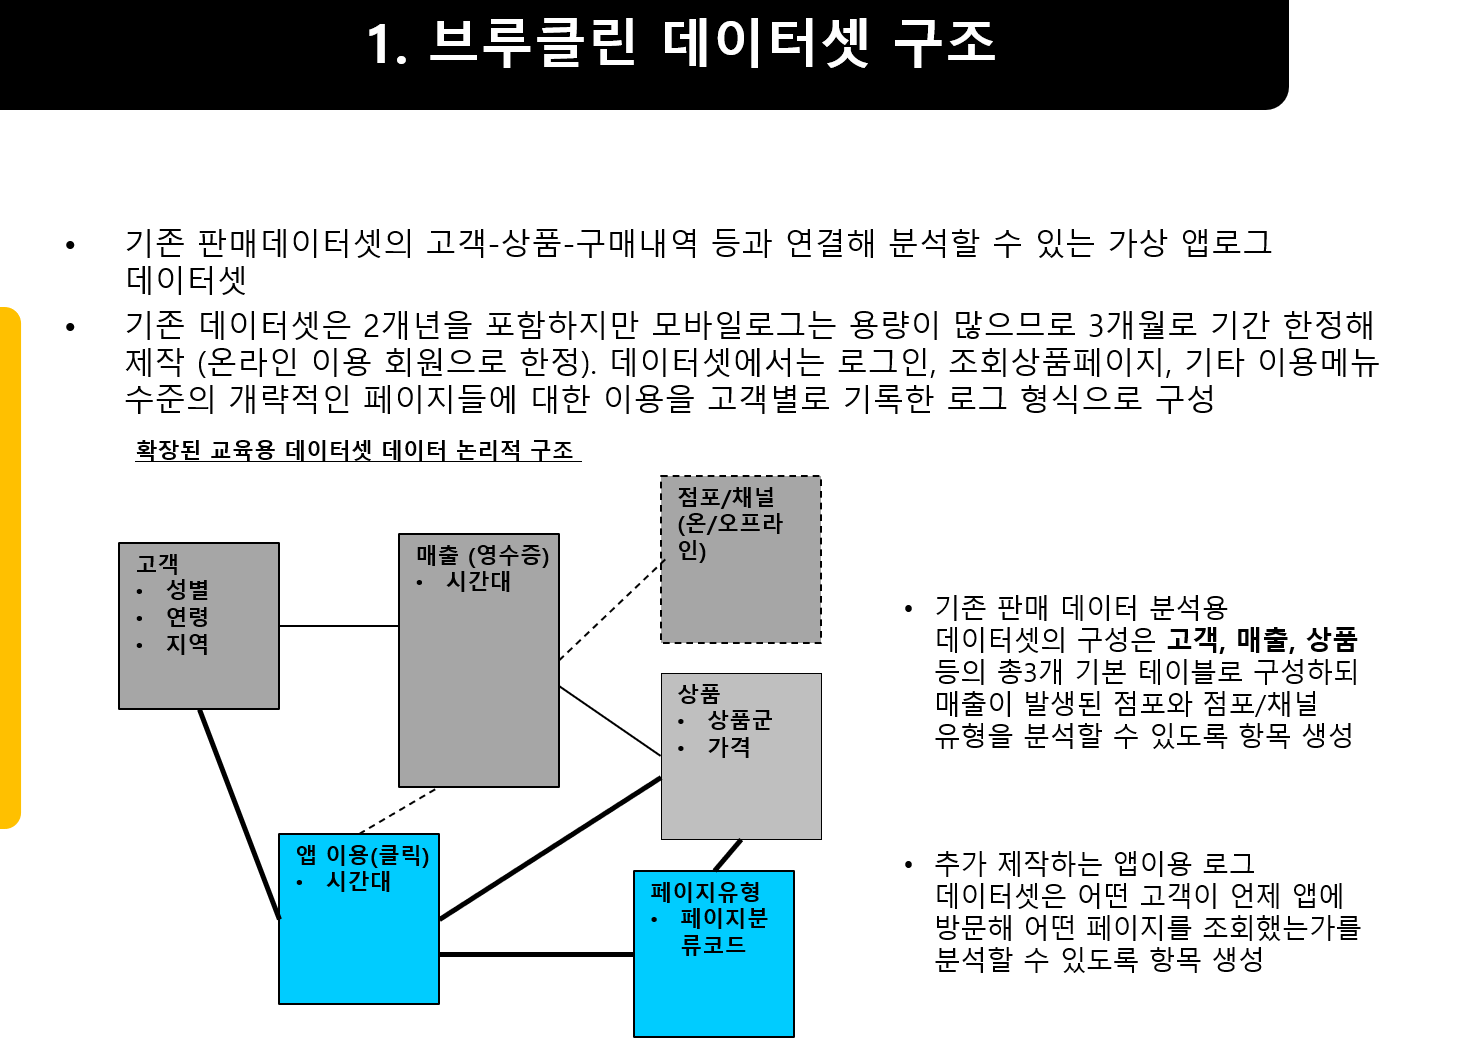

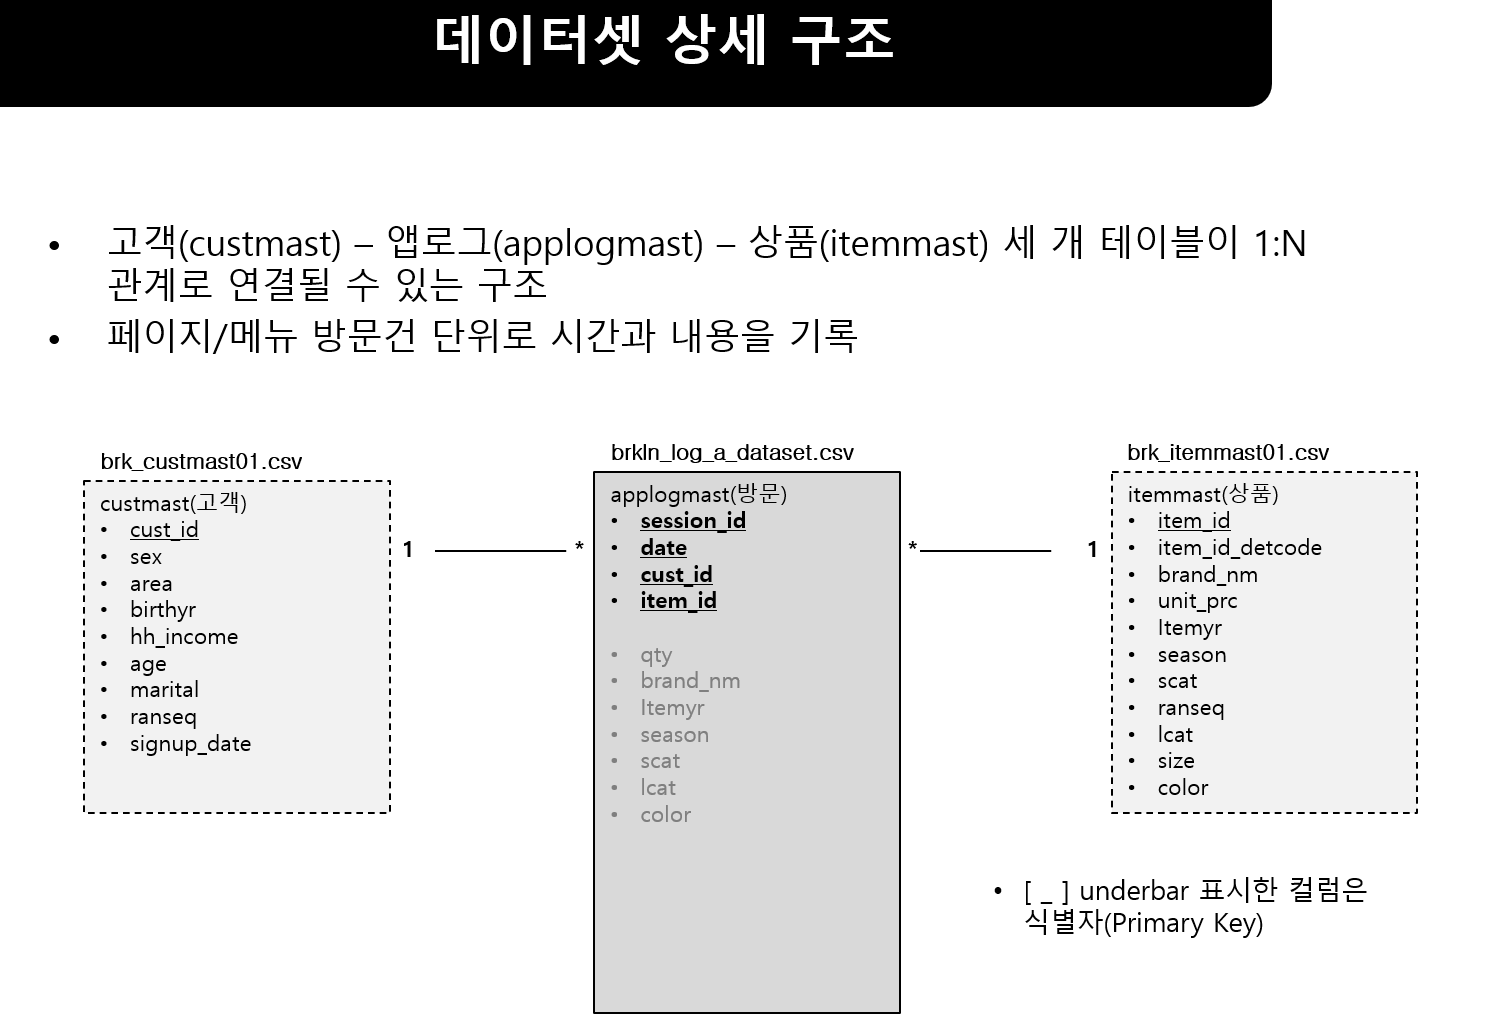

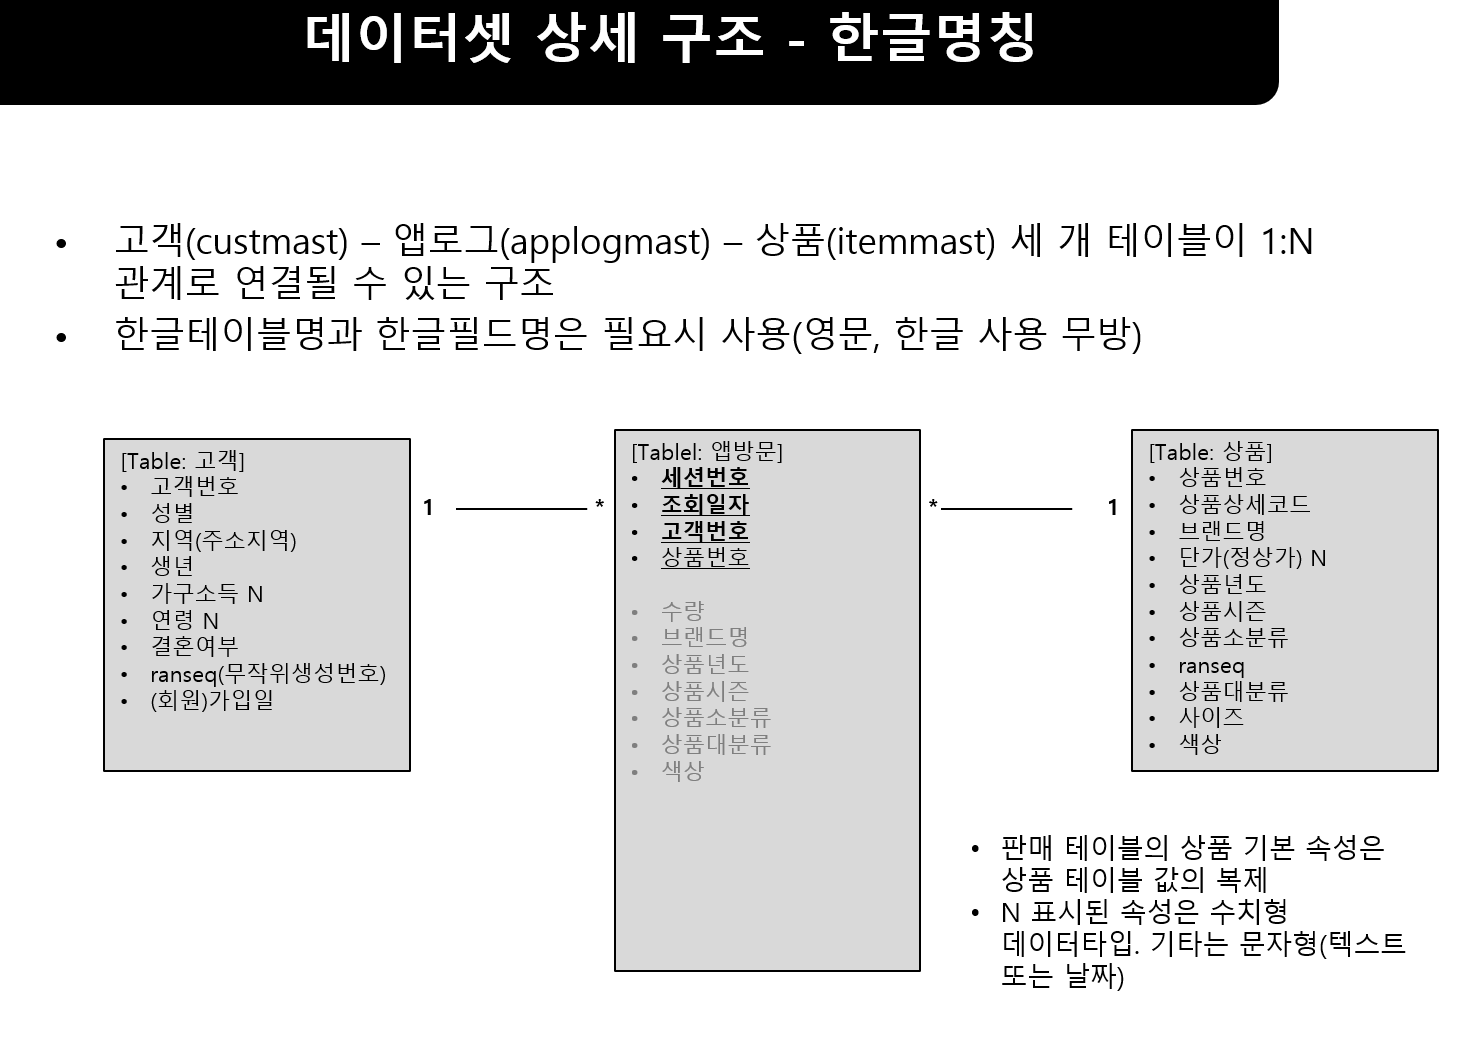

In [4]:
# 로그 데이터 불러오기

dflog = pd.read_csv(dataPath + 'brkln_log_a_dataset.csv', encoding='euc-kr').iloc[:,1:]

# 조회할 컬럼리스트 지정
cols2get = ['session_id', 'cust_id', 'date', 'item_id']
plusCols = ['age','sex', 'lcat','scat']

# 행과 열의 갯수 확인
print(dflog.shape)
# 데이터프레임의 중간에서 10개 행을 조회
dflog.head(int(len(dflog)/2)).tail(10)[cols2get+plusCols]

(56027, 13)


,session_id,cust_id,date,item_id,age,sex,lcat,scat
28003,2006200,B100087275,2020-11-23 11:55:59,SH1005007,39.0,M,여성캐주얼,바지
28004,2006200,B100087275,2020-11-23 11:55:51,ES2000709,39.0,M,여성캐주얼,바지
28005,2006200,B100087275,2020-11-23 11:56:06,ES2000709,39.0,M,여성캐주얼,바지
28006,2006200,B100087275,2020-11-23 11:56:16,ES2000709,39.0,M,여성캐주얼,바지
28007,2006200,B100087275,2020-11-23 11:56:21,event,39.0,M,NaN,NaN
28008,2006201,B100087275,2020-11-23 11:56:18,main,39.0,M,NaN,NaN
28009,2006201,B100087275,2020-11-23 11:56:09,SH1008006,39.0,M,여성캐주얼,치마
28010,2006200,B100087275,2020-11-23 11:56:00,SH1008906,39.0,M,남성캐주얼,셔츠
28011,2006202,B100005718,2020-11-23 12:05:47,ES2003802,29.0,F,여성캐주얼,재킷
28012,2006203,B100005718,2020-11-23 12:05:33,ES2003802,29.0,F,여성캐주얼,재킷


### 로그 데이터 구조 파악 - 기초적 탐색

In [5]:
# 세션수와 고객수 확인
len(dflog.session_id.unique()), len(dflog.cust_id.unique()), '고객당 세션수 비율 : ', len(dflog.session_id.unique())/ len(dflog.cust_id.unique())

(12629, 3567, '고객당 세션수 비율 : ', 3.5405102326885336)

In [6]:
# 일자별 방문 고객수

dflog['logDate'] = dflog.date.astype(str).str.slice(0,10)
logs01 = dflog[['logDate', 'cust_id']].drop_duplicates().groupby('logDate').count().reset_index()

# 날짜를 인덱스로 -- 날짜 데이터 타입으로 변경
logs01.index = pd.to_datetime(logs01.logDate, format='%Y-%m-%d')
# 남아있는 날짜 컬럼은 삭제
logs01 = logs01.drop('logDate', axis=1)
logs01.tail(10)

,cust_id
logDate,
2020-12-22,76
2020-12-23,85
2020-12-24,82
2020-12-25,97
2020-12-26,108
2020-12-27,142
2020-12-28,115
2020-12-29,79
2020-12-30,76


In [7]:
# 일자별 세션수

logs02 = dflog[['logDate', 'session_id']].drop_duplicates().groupby('logDate').count().reset_index()

# 날짜를 인덱스로 -- 날짜 데이터 타입으로 변경
logs02.index = pd.to_datetime(logs02.logDate, format='%Y-%m-%d')
# 남아있는 날짜 컬럼은 삭제
logs02 = logs02.drop('logDate', axis=1)
logs02.tail(10)

,session_id
logDate,
2020-12-22,122
2020-12-23,146
2020-12-24,135
2020-12-25,172
2020-12-26,192
2020-12-27,257
2020-12-28,185
2020-12-29,130
2020-12-30,130


고객수 대비 세션수 비율:  1.69562298603652


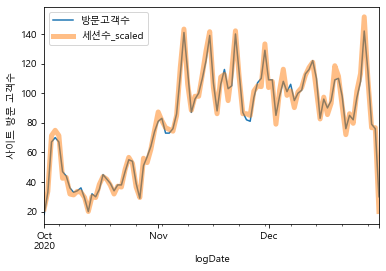

In [8]:
# 고객수 추이 먼저 플롯 작성
logs01.cust_id.plot()

# 세션수 추이 플롯 추가
# 세션수를 고객수 수준으로 추이 조절해서 비교
cust_session_ratio = logs02.session_id.sum() / logs01.cust_id.sum()
print('고객수 대비 세션수 비율: ', cust_session_ratio)

# 고객수 수준의 스케일로 조정된 세션수 추이 
(logs02.session_id/cust_session_ratio).plot(alpha=0.5, linewidth=5)
plt.ylabel('사이트 방문 고객수')
plt.legend(['방문고객수', '세션수_scaled'])
plt.show()

# 일자별 세션수와 고객수 간에 차이 거의 없음

### 페이지 종류별 조회수(클릭수) 분포 분석

In [9]:
# 상품 또는 페이지 종류를 의미하는 item_id 별 조회건수 확인

pd.DataFrame(dflog.item_id.value_counts().head(10))

,item_id
unclassified,9854
main,5217
SH1006708,4366
event,3725
ES2001905,2981
order,2804
search,2479
SH1005404,1067
SH1001209,1017
SH1005007,1017


In [10]:
# 특정 상품에 대한 것이 아닌  페이지의 종류들에 대해서 조회건수 확인

dflogPgtypes = pd.DataFrame(dflog.item_id.value_counts()).reset_index()
dflogPgtypes.columns = ['item_id', 'cntRec']
dflogPgtypes[~dflogPgtypes.item_id.astype(str).str.slice(0,2).isin(['SH', 'ES'])]

,item_id,cntRec
0,unclassified,9854
1,main,5217
3,event,3725
5,order,2804
6,search,2479
11,basket,530


- 상대적으로 다른 메뉴에 비해 이용이 많지는 않으나 basket 장바구니 항목 존재함

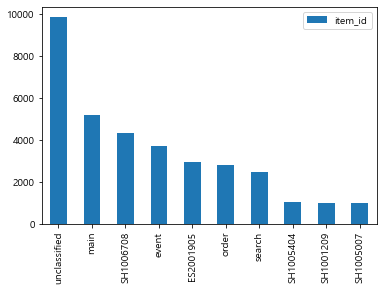

In [11]:
pd.DataFrame(dflog.item_id.value_counts().head(10)).plot(kind='bar')
plt.show()

In [12]:
# 상품 또는 페이지 종류를 의미하는 item_id 별 조회건수 확인

pvStat1 = cntnpcnt(dflog.item_id).sort_values('recCnt', ascending=False).head(10)
display(pvStat1)

print('조회수 Top 10 페이지들의 조회수 합계 비중 % ', pvStat1.pcntrecCnt.sum())

,item_id,recCnt,pcntrecCnt
816,unclassified,9854,17.587949
813,main,5217,9.311582
653,SH1006708,4366,7.792671
812,event,3725,6.648580
75,ES2001905,2981,5.320649
814,order,2804,5.004730
815,search,2479,4.424652
558,SH1005404,1067,1.904439
303,SH1001209,1017,1.815196
535,SH1005007,1017,1.815196


조회수 Top 10 페이지들의 조회수 합계 비중 %  61.625644778410404


[mini 연습문제] 

1. 메인 페이지는 방문하지 않은 고객의 비율은 몇 % 인가?



[mini 연습문제] 
1. 이벤트 페이지를 방문한 고객 중 특정상품 페이지는 방문하지 않은 고객의 비율은 몇 % 인가?



[mini 연습문제]  <font color='blue'>**(Advanced)**</font> 
1. 메인페이지 방문 **직전**에 검색 페이지를 방문하는 고객의 비율은 전체 고객중  몇 % 인가?


In [55]:
dft001 = dflog[dflog.item_id.isin(['search', 'main'])][['cust_id', 'date', 'item_id']].sort_values(['cust_id', 'date']) 
dft001 = dft001[~dft001.cust_id.isna()]
dft001['prevPage'] = dft001.item_id.shift(1)
dft001 = dft001[dft001.item_id!=dft001.prevPage]
dft001 = dft001[dft001.item_id=='main']
display(dft001.tail())

len(dft001.cust_id.unique())


,cust_id,date,item_id,prevPage
32843,B100099580,2020-11-30 08:19:50,main,search
34111,B100099580,2020-12-01 15:53:35,main,search
54568,B100099820,2020-12-28 17:08:01,main,search
19217,B100099910,2020-11-13 10:46:50,main,search
13327,B100099976,2020-11-05 19:33:11,main,search


1444

### 로그데이터와 판매데이터 연계 분석

In [41]:
# 로그 데이터와 같은 기간에 해당하는 판매 내역 추출

# 로그데이터의 기간 확인
print(dflog.logDate.min(), '~' ,dflog.logDate.max())

# 로그데이터 기간을 사용한 데이터 추출
sales_l01= sales[sales.datea>=dflog.logDate.min()][['datea','item_id']]
sales_l01

2020-10-01 ~ 2020-12-31


,datea,item_id
61,2020-11-21,SH1008707
131,2020-11-22,SH1008901
163,2020-10-14,ES2000504
166,2020-10-14,SH1001707
274,2020-12-25,SH1003703
...,...,...
41931,2020-10-01,SH1001702
41932,2020-10-01,SH1001203
41933,2020-10-01,ES2001705
41934,2020-12-30,SH1008304


In [16]:
# 판매 데이터 집계와 로그 데이터 집계 결합

# 로그데이터 집계
dftmpa = pd.DataFrame(dflog.item_id.value_counts()).reset_index()

# 판매 데이터 집계
dftmpb = pd.DataFrame(sales_l01.item_id.value_counts()).reset_index()

# 결합
dfitem_logstat01 = dftmpa.merge(dftmpb, how='left', on='index')
dfitem_logstat01.columns = ['item_idLog', 'cntLog', 'cntSales']

# 상품이 아니거나 판매량 없는 상품 값 채우기
dfitem_logstat01.fillna(0, inplace=True)
dfitem_logstat01

,item_idLog,cntLog,cntSales
0,unclassified,9854,0.0
1,main,5217,0.0
2,SH1006708,4366,15.0
3,event,3725,0.0
4,ES2001905,2981,6.0
...,...,...,...
812,SH1002404,1,1.0
813,ES2004507,1,2.0
814,ES2004201,1,1.0
815,SH1002604,1,1.0


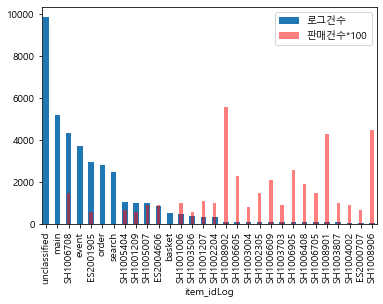

In [17]:
# 로그 건수와 판매 건수를 한 챠트에서 비교

# pandas plot 을 사용하기 위해 item_id 를 인덱스로 지정
dfitem_logstat01.index = dfitem_logstat01.item_idLog
# 먼저 로그 건수 시각화
dfitem_logstat01.head(30).cntLog.plot(kind='bar')

# 조회건수에 비해 판매건수가 통상 월등히 작으므로 대략적으로 스케일 조절해서 시각화
(dfitem_logstat01.head(30).cntSales*100).plot(kind='bar', color='red', alpha=0.5, width=0.3)

plt.legend(['로그건수','판매건수*100'])
plt.show()


# (options)
# 정확한 비교를 위해서 온라인채널 판매건수만 반영하는 방법도 있음
# 로그가 존재하는 고객에 한정해서 비교하는 것도 필요

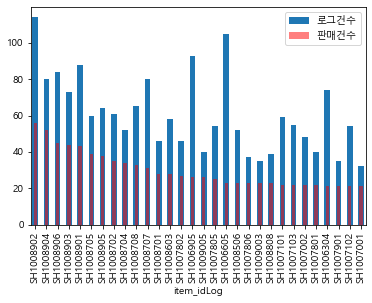

In [18]:
# 로그 건수와 판매 건수를 한 챠트에서 비교하되
# 판매건수가 많은 순 상위 item만 시각화

# 동일한 데이터를 판매건수 순으로 정렬
dfitem_logstat02 = dfitem_logstat01.copy().sort_values('cntSales', ascending=False)

# pandas plot 을 사용하기 위해 item_id 를 인덱스로 지정
dfitem_logstat02.index = dfitem_logstat02.item_idLog
# 먼저 로그 건수 시각화
dfitem_logstat02.head(30).cntLog.plot(kind='bar')

# 조회건수에 비해 판매건수가 크지 않으므로 스케일 조절하지 않음 
(dfitem_logstat02.head(30).cntSales).plot(kind='bar', color='red', alpha=0.5, width=0.3)

plt.legend(['로그건수','판매건수'])
plt.show()

# 전체적으로는 판매건수가 많은 상품들이 로그건수도 많은 패턴

### 사이트 방문시간대 분석

In [19]:
# 방문시간대 분포 분석

from datetime import datetime

# 문자형으로 된 일시 데이터에서 시간(hour)만 추출하려면
# 먼저 datetime으로 변경한 후 시간 부분을 추출하는 함수를 적용

# 스트링 형식의 방문일시를 datetime 형식으로 변경
logDateSeries = pd.to_datetime(dflog.date, infer_datetime_format=True)
smplLogSeries = logDateSeries.sample(5)
print(smplLogSeries)

# 시간만 추출
smplLogSeries.dt.hour

28353   2020-11-23 19:01:57
51739   2020-12-25 16:34:44
45004   2020-12-15 19:15:15
44985   2020-12-15 18:41:43
22877   2020-11-17 07:58:29
Name: date, dtype: datetime64[ns]


28353    19
51739    16
45004    19
44985    18
22877     7
Name: date, dtype: int64

In [20]:
# 시간대별 로그건수 집계
logHrStat = logDateSeries.dt.hour.value_counts().reset_index()

# 로그건수 가장 많은 시간대 5개 확인
# value_counts() 는 값이 큰 것 부터 정렬해서 제공하므로 top 5 추출
display(logHrStat.head())

,index,date
0,17,5782
1,15,5765
2,11,5380
3,22,4870
4,16,4518


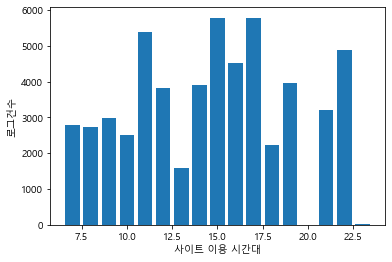

In [21]:
# 시간대 순서로 로그건수 많은 정도를 확인 - 시간대별 방문 빈도 분포 확인

plt.bar(logHrStat['index'], logHrStat.date)
# 시간대 ('index' 컬럼) 의 형식이 integer 이기 때문에 순서대로 자동정렬
# 형식을 문자로 바꾸면 값 그대로 표시
plt.xlabel('사이트 이용 시간대')
plt.ylabel('로그건수')
plt.show()

#### 성별에 따른 방문시간대 차이 확인

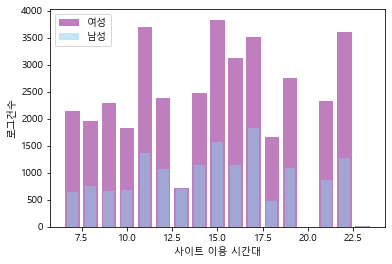

In [22]:
from datetime import datetime

# 여성 고객의 방문건만 사용해서 시각화

# 스트링 형식의 방문일시를 datetime 형식으로 변경
logDateSeries = pd.to_datetime(dflog[dflog.sex=='F'].date, infer_datetime_format=True)
# 시간만 추출
# 시간대별 로그건수 집계
logHrStat = logDateSeries.dt.hour.value_counts().reset_index()
logHrStat_F = logHrStat.copy()
plt.bar(logHrStat['index'], logHrStat.date, alpha=0.5, color='purple')

# 동일 방식으로 남성 고객의 방문건만 사용해서 시각화

logDateSeries = pd.to_datetime(dflog[dflog.sex=='M'].date, infer_datetime_format=True)
logHrStat = logDateSeries.dt.hour.value_counts().reset_index()
logHrStat_M = logHrStat.copy()
plt.bar(logHrStat['index'], logHrStat.date, alpha=0.5, color='skyblue', width=0.6)
plt.xlabel('사이트 이용 시간대')
plt.ylabel('로그건수')
plt.legend(['여성','남성'])
plt.show()

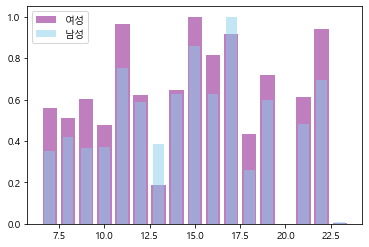

In [23]:
# zrmx_scl 을 활용해서 척도를 0~1 사이로 통일 -- 구성비 비교에 중점

# 두 dataframe을 병합  -- 시간 단위로 
dfhrLogStat01 = pd.merge(logHrStat_F, logHrStat_M, how='inner', on='index')
# 혼동 방지를 위해 컬럼명 변경
dfhrLogStat01.columns = ['hour_id', 'cntLog_F', 'cntLog_M']
# zrmx_scl 활용한 시각화
plt.bar(dfhrLogStat01.hour_id, zrmx_scl(dfhrLogStat01.cntLog_F),
        alpha=0.5, color='purple')
plt.bar(dfhrLogStat01.hour_id, zrmx_scl(dfhrLogStat01.cntLog_M),
        alpha=0.5, color='skyblue', width=0.6)
plt.legend(['여성','남성'])
plt.show()

# 직장인 비율이 높은 남성 경우 점심시간 직후인 1시대 특히 상대적인 이용비중 높음

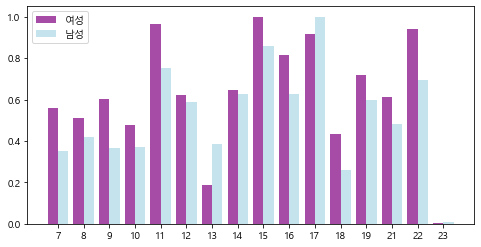

In [24]:
# 여러개 bar chart를 옆으로 배치 (그룹별) 하는 경우

# X축의 순서가 섞이지 않도록 미리 정렬
dfhrLogStat01 = dfhrLogStat01.sort_values('hour_id')

# X축의 좌표
X_axis = np.arange(len(dfhrLogStat01))

# 막대가 옆으로 많아졌기에 좌우로 폭을 좀 더 넓게
plt.figure(figsize=(8,4))

# X축 좌표 기준점 보다 약간 왼쪽에 막대 표시
plt.bar(X_axis - 0.2, zrmx_scl(dfhrLogStat01.cntLog_F), 0.4, label = '여성',
       alpha=0.7, color='purple')
# X축 좌표 기준점 보다 약간 오른쪽에 막대 표시
# 막대의 width 폭을 좁혀서(0.4) 겹치지 않도록
plt.bar(X_axis + 0.2, zrmx_scl(dfhrLogStat01.cntLog_M), 0.4, 
        # 각 막대에 라벨을 지정한 후 범례에서는 한번에 표시
        label = '남성',
        alpha=0.7, color='lightblue')

# X축의 좌표별 label
plt.xticks(X_axis, dfhrLogStat01.hour_id)

# 이미 지정된 label 들을 사용해서 범례 일괄 표시
plt.legend()
plt.show()

,index,date
2,0,2230
6,1,1758
3,2,2156
5,3,1897
4,4,1907
1,5,2499
0,6,2857


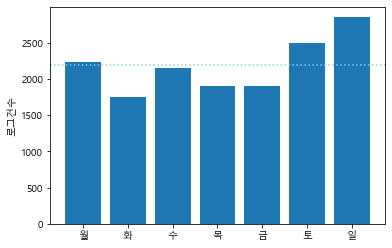

In [25]:
# 방문요일 분석

from datetime import datetime

# 날짜 형식 시리즈에서 요일 추출 dt.dayofweek
logDows = logDateSeries.dt.dayofweek
dflogDows = pd.DataFrame(logDows.value_counts()).reset_index().sort_values('index')
display(dflogDows)

plt.bar(['월', '화', '수', '목', '금', '토', '일'],dflogDows.date)
plt.ylabel('로그건수')
plt.axhline(dflogDows.date.mean(), color='skyblue', linestyle=":")
plt.show()

**[추가 연습문제]** <br><br>
요일별 로그건수와 판매건수간 관계는 ??

[mini 연습문제] 
1. 대분류, 소분류 상품군별 로그 건수의 분포는?



[mini 연습문제]
1. 평일 점심시간 (11:45~12:10) 에 방문한 고객의 비율은 전체 사이트 방문기록 있었던 고객중 몇 %인가?

### 고객별 구매와 로그 양쪽의 특성을 비교해서 고객을 세분화한다면?

In [27]:
# 고객별로 온라인사이트를 방문한 날짜들
dfcustlogD = dflog[['cust_id','logDate']].drop_duplicates()
display(dfcustlogD.tail())

len(dfcustlogD.cust_id.unique())

,cust_id,logDate
56019,B100037176,2020-12-31
56020,B100016017,2020-12-31
56022,B100012043,2020-12-31
56024,B100022944,2020-12-31
56026,B100088228,2020-12-31


3567

In [28]:
# 고객별로 구매한 일자들
dfcustsalesD = sales[sales.datea>='2020-10-01'][['cust_id','datea']].drop_duplicates()
display(dfcustsalesD.tail())

len(dfcustsalesD.cust_id.unique())

,cust_id,datea
41928,B100063572,2020-11-30
41931,B100044469,2020-10-01
41933,B100044222,2020-10-01
41934,B100013999,2020-12-30
41935,B100025084,2020-11-30


3817

In [29]:
# 온라인에 방문했으면서 구매도 있었던 고객의 수는?

len(dfcustsalesD[dfcustsalesD.cust_id.isin(dfcustlogD.cust_id.unique())].cust_id.unique())

3567

In [30]:
# 온라인 이용이든 구매든 있었던 고객 전체 리스트 생성
dftmpa1 = dfcustsalesD[['cust_id']].drop_duplicates()
dftmpa2 = dfcustlogD[['cust_id']].drop_duplicates()

# 온라인 이용의 고객리스트와 구매고객리스트를 결합한 후 중복 제거
dfvnp01 = pd.concat([dftmpa1,dftmpa2]).drop_duplicates()
print(dfvnp01.shape) 

# df visit and purchase
dfvnp01.sample(5)

(3817, 1)


,cust_id
28861,B100099525
39707,B100026962
33099,B100055789
24045,B100029311
39390,B100039109


In [31]:
# 고객별 온라인 방문일수 집계

dfcustlogDs = dfcustlogD.groupby('cust_id').count().reset_index()
dfcustlogDs.sample(5).sort_values('logDate')

,cust_id,logDate
2982,B100083768,1
132,B100003582,2
1802,B100052304,2
984,B100028595,2
980,B100028524,2


In [32]:
# 고객별 구매일수 집계

dfcustsalesDs = dfcustsalesD.groupby('cust_id').count().reset_index()
dfcustsalesDs.sample(5).sort_values('datea')

,cust_id,datea
3651,B100096133,1
221,B100005903,1
1830,B100049504,1
1345,B100036453,1
605,B100016017,2


In [33]:
dfvnp01 = dfvnp01.merge(dfcustlogDs, how='left', on='cust_id')
dfvnp01 = dfvnp01.merge(dfcustsalesDs, how='left', on='cust_id')
dfvnp01

,cust_id,logDate,datea
0,B100057706,3.0,2.0
1,B100086574,1.0,1.0
2,B100068561,1.0,1.0
3,B100047061,4.0,1.0
4,B100078682,NaN,1.0
...,...,...,...
3812,B100063572,1.0,1.0
3813,B100044469,2.0,1.0
3814,B100044222,2.0,1.0
3815,B100013999,NaN,1.0


In [34]:
dfvnp01.fillna(0, inplace=True)

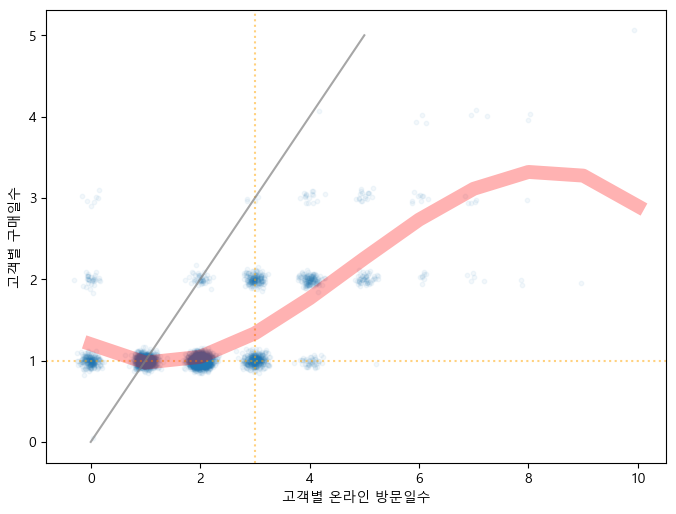

In [35]:
# 챠트의 해상도 높게 설정
plt.figure(figsize=(8,6), dpi=100)
plt.scatter(rjitt(dfvnp01.logDate), rjitt(dfvnp01.datea), 
            alpha=0.05, s=10)
plt.xlabel('고객별 온라인 방문일수')
plt.ylabel('고객별 구매일수')
plt.axvline(dfvnp01.logDate.quantile(0.8), color='orange', linestyle=':', alpha=0.5)
plt.axhline(dfvnp01.datea.quantile(0.8), color='orange', linestyle=':', alpha=0.5)

varx = dfvnp01.logDate
vary = dfvnp01.datea
plt.plot(np.unique(varx), np.poly1d(np.polyfit(varx, vary, 3))(np.unique(varx)), 
         color='red', linewidth=10, alpha=0.3)

# 대각선을 보조선으로 추가
maxVal = np.max(vary)
plt.plot([0,maxVal], [0,maxVal], color='grey', alpha=0.7)
plt.show()

- 3개월 중 2일이상 구매한 고객의 수가 많지 않음
- 반면 사이트 방문은 3일 이상인 경우도 20% 인근 존재
- 온라인방문이 매우 빈번해진다고 끝없이 구매가 증가하지는 않음

In [36]:
# 2일이상 구매한 고객의 수 확인

len(dfvnp01[dfvnp01.datea>1])

518

In [37]:
# 전체 고객수에서의 비율 산출

len(dfvnp01[dfvnp01.datea>1]) / len(dfvnp01) * 100, "%"

(13.57086717317265, '%')

In [38]:
# 구매고객의 온라인 방문여부 비율 산출

len(dfvnp01[(dfvnp01.datea>0) & (dfvnp01.logDate>0)]) / len(dfvnp01[dfvnp01.datea>0]) * 100, "%"

(93.44863731656184, '%')

**[추가로 검토필요한 분석 주제]**
- 다수의 고객들이 온라인도 방문하는데 온라인을 전혀 방문하지 않는 고객들은 어떤 특성을 가지고 있는가?
- 연령, 성별, 지역 등 기본적인 특성 자체가 다른가?
- 혹시 온라인을 방문하지 않는 고객들이 오히려 더 구매액, 고객가치 등이 큰 고객들은 아닌가?

**[응용문제]**
- 온라인에 방문했지만 같은 날 오프라인 매장에서 구매가 있었던 고객의 수는? -- 온라인 방문고객 중 몇%에 해당하는가?
- 이런 유형의 고객들은 오프라인 방문 전후 몇일 정도에 활발하게 온라인 사이트를 방문하는가? (**탐색과 사후평가 기간**?)

### seaborn을 활용한 시각화

- **seabonr library** : statistical data visualization
- https://seaborn.pydata.org/
- Seaborn is a Python data visualization library based on matplotlib.
- It provides a high-level interface for drawing attractive and informative statistical graphics.

,dow,date_str,date
64,4,2020-12-18,670
7,0,2020-11-23,791
61,4,2020-11-27,832
62,4,2020-12-04,800
48,3,2020-12-03,585


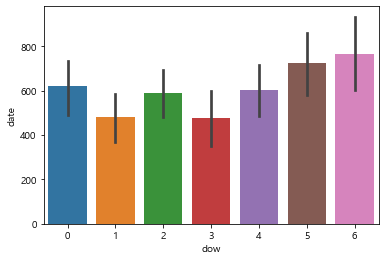

In [77]:
# seaborn 로딩
import seaborn as sns

# 일자별 요일별 로그건수 집계 - 시각화용 데이터 준비
dowStat001 = dflog[['date']]
logDateSeries = pd.to_datetime(dflog.date, infer_datetime_format=True)
logDows = logDateSeries.dt.dayofweek
dowStat001['dow'] = np.array(logDows)

# 일시 데이터 컬럼에서 일자만 추출
dowStat001['date_str'] = dowStat001.date.str.slice(0,10)

# 하루단위로 집계 -- dow 요일은 테이블에서 사라지지 않도록 추가
dowStat002 = dowStat001.groupby(['dow','date_str']).count().reset_index()
display(dowStat002.sample(5))

# 막대 챠트 시각화
sns.barplot(x="dow", y="date", data=dowStat002)
# 표시되는 값은 일자별 값의 평균
# 막대에 기본적으로 추가 표시되는 검정색 선은 Bootstrap confidence interval 신뢰구간
plt.show()


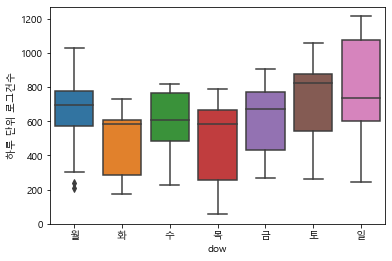

In [83]:
# seaborn으로 박스플롯 그리기

ax = sns.boxplot(x="dow", y="date", data=dowStat002)

# y축의 라벨 변경
ax.set_ylabel('하루 단위 로그건수')

# x축의 xticks 박스별 라벨 변경
dow_names = ['월', '화', '수', '목', '금', '토', '일']
ax.set_xticklabels(dow_names)

plt.show()

### sns.lineplot

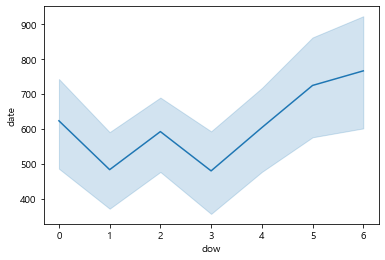

In [90]:
# 95% 신뢰구간을 함께 표시해주는 선챠트
# boxplot을 사용하지 않더라도 분포 변화 파악 가능

ax = sns.lineplot(x="dow", y="date", data=dowStat002)
plt.show()

### sns.relplot -- relationship plot

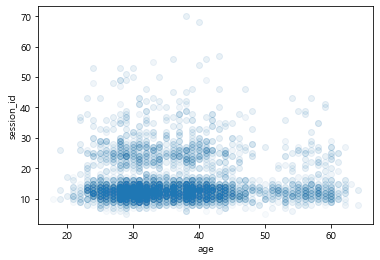

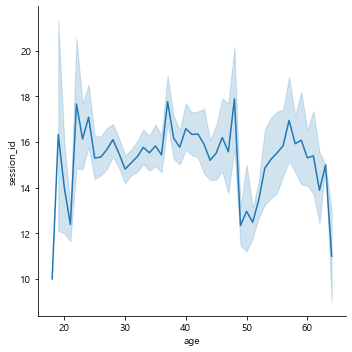

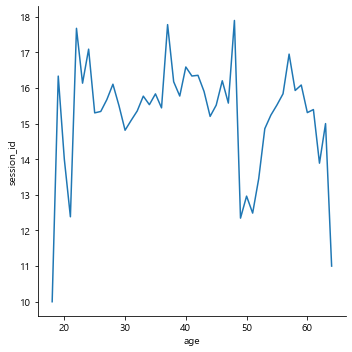

In [75]:
dflogCnt201 = dflog[['cust_id', 'session_id']].groupby('cust_id').count().reset_index()
dflogCnt202 = dflog[['cust_id', 'age','sex','brand_nm']].drop_duplicates()
dflogCnt202
dflogCnt203 = pd.merge(dflogCnt201, dflogCnt202, how='inner', on='cust_id')

# matplotlib의 산점도를 사용한 관계 검토
plt.scatter(dflogCnt203.age, dflogCnt203.session_id,
           alpha=0.03)
plt.xlabel('age')
plt.ylabel('session_id')
plt.show()


# x 축 기준 y 값들의 평균값을 표시
# 동일한 x 값에 대해 복수의 y 값이 존재하므로 
# confidence interval 신뢰구간을 참고로 제공
sns.relplot(x="age", y="session_id", data=dflogCnt203,
           kind="line") # with 95% confidence interval
plt.show()

sns.relplot(x="age", y="session_id", data=dflogCnt203,
            kind="line", 
            ci=None) # without CI 신뢰구간 정보가 필요없는 경우 표시하지 않도록 지정
plt.show()

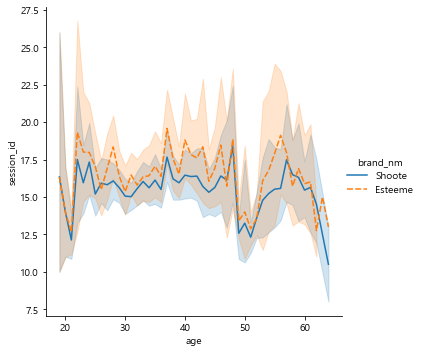

In [74]:
# 하나의 챠트에 두 개 값들을 표시해 비교

sns.relplot(data=dflogCnt203,
            x="age", y="session_id", 
            hue="brand_nm", # hue 옵션을 사용하지 않는 경우와 비교 !!
            style="brand_nm", # style 옵션을 사용하지 않는 경우와 비교 !!
            kind="line" # line plot 선 형태의 챠트
           )  
            # with 95% confidence interval  95% 신뢰구간 자동 표시

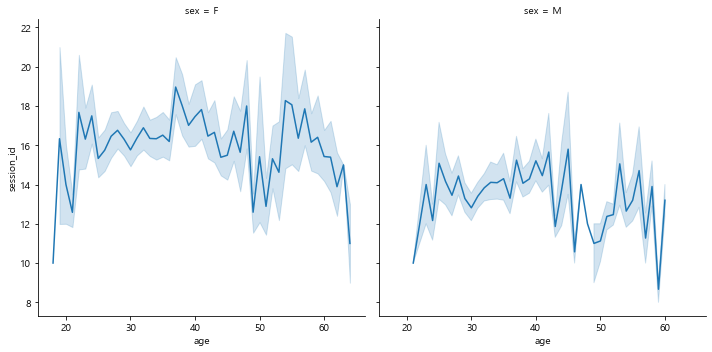

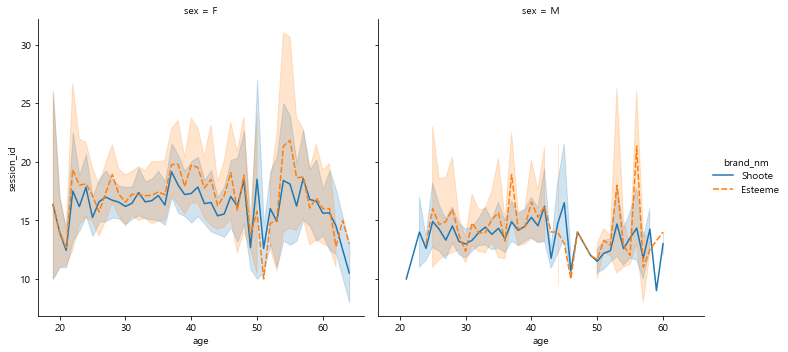

In [62]:
# 집단별 별도의 챠트를 작성해 비교

sns.relplot(data=dflogCnt203,
            x="age", y="session_id", 
            col='sex',
            # hue="brand_nm", style="brand_nm",
            kind="line")
plt.show()

sns.relplot(data=dflogCnt203,
            x="age", y="session_id", 
            col='sex',
            hue="brand_nm", style="brand_nm",
            kind="line")
plt.show()